In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [ ]:
import numpyro.distributions as dist
from hbmep.model import BaseModel


class MixedEffects(BaseModel):
    LINK = "mixed_effects"

    def __init__(self, config: Config):
        super(MixedEffects, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def fn(self, x, a, b, v, L, ell, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -ell + jnp.true_divide(
                    H + ell,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + ell, ell),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        n_baseline = 1
        n_delta = n_feature0 - 1

        """ Fixed Effects (Baseline) """
        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_baseline", n_baseline):
                a_fixed_mean = numpyro.sample("a_fixed_mean", dist.TruncatedNormal(5, 10, low=0))
                a_fixed_scale = numpyro.sample("a_fixed_scale", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject):
                    a_fixed = numpyro.sample(
                        "a_fixed", dist.TruncatedNormal(a_fixed_mean, a_fixed_scale, low=0)
                    )

        """ Random Effects (Delta) """
        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_delta", n_delta):
                a_random_mean = numpyro.sample("a_random_mean", dist.Normal(0, 10))
                a_random_scale = numpyro.sample("a_random_scale", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject):
                    a_random = numpyro.sample("a_random", dist.Normal(a_random_mean, a_random_scale))

                    """ Penalty """
                    penalty_for_negative_a = (jnp.fabs(a_fixed + a_random) - (a_fixed + a_random))
                    numpyro.factor("penalty_for_negative_a", -penalty_for_negative_a)

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(100))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(100))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(1))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(100))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(10))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0):
                """ Hyper-priors """
                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("sigma_ell", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject):
                    """ Priors """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_fixed, a_fixed + a_random], axis=1)
                    )

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                    ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                    ell = numpyro.deterministic("ell", jnp.multiply(ell_scale, ell_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .05))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(30))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        ell=ell[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )


In [2]:
import numpyro.distributions as dist
from hbmep.model import BaseModel


class RectifiedLogistic(BaseModel):
    LINK = "RectifiedLogistic"

    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
            global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
            global_sigma_l = numpyro.sample("global_sigma_l", dist.HalfNormal(100))
            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=10))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=10 / 150))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_v_raw = numpyro.sample("sigma_v_raw", dist.HalfNormal(scale=1))
                sigma_v = numpyro.deterministic(site.sigma_v, global_sigma_v * sigma_v_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_l_raw = numpyro.sample("sigma_l_raw", dist.HalfNormal(scale=1))
                sigma_l = numpyro.deterministic("sigma_l", global_sigma_l * sigma_l_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, sigma_v * v_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    l_raw = numpyro.sample("l_raw", dist.HalfNormal(scale=1))
                    l = numpyro.deterministic("l", sigma_l * l_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[subject, feature0]
                    + jnp.where(
                        intensity <= a[subject, feature0],
                        0,
                        -l[subject, feature0]
                        + (
                            (H[subject, feature0] + l[subject, feature0])
                            / jnp.power(
                                1
                                + (
                                    (
                                        -1
                                        + jnp.power(
                                            (H[subject, feature0] + l[subject, feature0]) / l[subject, feature0],
                                            v[subject, feature0]
                                        )
                                    )
                                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0]))
                                ),
                                1 / v[subject, feature0]
                            )
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + g_2[subject, feature0] * jnp.power(1 / (mu + 1), p[subject, feature0])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )

In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/figures/fig_1.toml"
CONFIG = Config(toml_path=toml_path)
BASELINE = BaseModel(config=CONFIG)

src = "/home/vishu/data/hbmep-processed/J_RCML_000/data.csv"
DF = pd.read_csv(src)

src = "/home/vishu/data/hbmep-processed/J_RCML_000/mat.npy"
MAT = np.load(src)
mep_response = ['LADM', 'LBiceps', 'LBicepsFemoris', 'LDeltoid', 'LECR', 'LFCR', 'LTriceps', 'RBiceps']

DF = DF.sort_values(by=[BASELINE.intensity]).copy()
MAT = MAT[DF.index.values]
DF = DF.reset_index(drop=True).copy()


2023-11-22 11:05:06,760 - hbmep.config - INFO - Verifying configuration ...
2023-11-22 11:05:06,761 - hbmep.config - INFO - Success!
2023-11-22 11:05:06,777 - hbmep.model.baseline - INFO - Initialized base_model


In [4]:
c, muscle, const = ("-C5M", "amap08"), "LADM", 2.2
ind = DF[BASELINE.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
temp_DF = DF[ind].reset_index(drop=True).copy()
df = pd.DataFrame(
    temp_DF[BASELINE.intensity],
    columns=[BASELINE.intensity]
)
df[BASELINE.response[0]] = temp_DF[muscle] / const

mep_response_ind = [i for i, _response in enumerate(mep_response) if _response == muscle][0]
mat = MAT[ind, :, mep_response_ind][..., None]

c, muscle, const =("C6M-C7L", "amap08"), "LECR", 1

ind = DF[BASELINE.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
temp_DF = DF[ind].reset_index(drop=True).copy()
df[BASELINE.response[1]] = temp_DF[muscle] / const

mep_response_ind = [i for i, _response in enumerate(mep_response) if _response == muscle][0]
mat = np.concatenate([
    mat,
    MAT[ind, :, mep_response_ind][..., None]
], axis=-1)

df[BASELINE.subject] = 0
df[BASELINE.features[0]] = 0

dest = os.path.join(BASELINE.build_dir, "mat.npy")
np.save(dest, mat)


In [5]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/figures/fig_1.toml"
config = Config(toml_path=toml_path)

model = RectifiedLogistic(config=config)
df, encoder_dict = model.load(df=df)

model.plot(df=df, encoder_dict=encoder_dict)

2023-11-22 11:05:12,680 - hbmep.config - INFO - Verifying configuration ...
2023-11-22 11:05:12,680 - hbmep.config - INFO - Success!
2023-11-22 11:05:12,682 - hbmep.model.baseline - INFO - Initialized base_model
2023-11-22 11:05:12,682 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/
2023-11-22 11:05:12,682 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/
2023-11-22 11:05:12,683 - hbmep.dataset.core - INFO - Processing data ...
2023-11-22 11:05:12,684 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-11-22 11:05:12,685 - hbmep.model.baseline - INFO - Rendering ...


2023-11-22 11:05:12,791 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/dataset.pdf
2023-11-22 11:05:12,791 - hbmep.utils.utils - INFO - func:plot took: 0.11 sec


In [6]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-11-22 11:05:16,250 - hbmep.model.baseline - INFO - Running inference with base_model ...


AttributeError: type object 'Site' has no attribute 'mu_a'

In [7]:
prediction_df = model.make_prediction_dataset(df=df, num_points=1000)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-01 13:10:45,867 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec


2023-11-01 13:10:58,162 - hbmep.utils.utils - INFO - func:predict took: 12.30 sec
2023-11-01 13:10:58,196 - hbmep.model.baseline - INFO - Rendering ...
2023-11-01 13:10:59,110 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/recruitment_curves.pdf
2023-11-01 13:10:59,112 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.95 sec
2023-11-01 13:10:59,174 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-11-01 13:11:04,334 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/posterior_predictive_check.pdf
2023-11-01 13:11:04,336 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 5.22 sec
2023-11-01 13:11:04,336 - hbmep.utils.utils - INFO - func:render_predictive_check took: 5.22 sec


In [8]:
time_const = 1000

obs = np.array(posterior_predictive[site.obs]) * time_const
obs_map = obs.mean(axis=0)

obs_hpdi = hpdi(obs, prob=.95)


In [9]:
def fn(x, a, b, v, l, L, H):
    return(
        L
        + jnp.where(
            x <= a,
            0,
            -l
            + (
                (H + l)
                / jnp.power(
                    1
                    + (
                        (
                            -1
                            + jnp.power(
                                (H + l) / l,
                                v
                            )
                        )
                        * jnp.exp(-b * (x - a))
                    ),
                    1 / v
                )
            )
        )
    )

fn_prime = jax.grad(fn, argnums=0)

a, b, v, l, L, H = \
    np.array(posterior_samples[site.a]), np.array(posterior_samples[site.b]), np.array(posterior_samples[site.v]), np.array(posterior_samples["l"]), np.array(posterior_samples[site.L]), np.array(posterior_samples[site.H])
(subject, n_subject), (features, n_features), (intensity, n_data), = model._collect_regressors(df=prediction_df)
intensity = intensity.reshape(-1, 1)
intensity = np.tile(intensity, (a.shape[0], 1, model.n_response))
feature0 = features[0].reshape(-1,)

params = [a, b, v, l, L, H]
params = [u[:, subject, feature0] for u in params]

fn_out = fn(intensity, *tuple(params))
fn_out = np.array(fn_out)

fn_prime_out = jax.vmap(jax.vmap(jax.vmap(fn_prime)))(intensity, *tuple(params))
fn_prime_out = np.array(fn_prime_out) * time_const
fn_prime_out.shape


(16000, 1000, 2)

In [10]:
a_map = a.mean(axis=0)
obs_map = obs.mean(axis=0)

In [11]:
muscle_ind = 0
sns.lineplot(x=prediction_df[model.intensity], y=fn_out[..., muscle_ind].mean(axis=0), color=colors[muscle_ind], label="Recruitment Curve")
sns.lineplot(x=prediction_df[model.intensity], y=fn_prime_out[..., muscle_ind].mean(axis=0), color='black', linestyle="--", label="gradient")

plt.axvline(x=135)
plt.xticks([0, 100, 135, 200]);

NameError: name 'colors' is not defined

<Axes: xlabel='pulse_amplitude'>

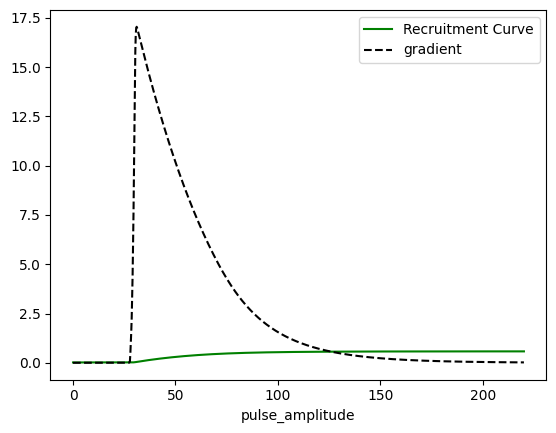

In [ ]:
muscle_ind = 1
sns.lineplot(x=prediction_df[model.intensity], y=fn_out[..., muscle_ind].mean(axis=0), color=colors[muscle_ind], label="Recruitment Curve")
sns.lineplot(x=prediction_df[model.intensity], y=fn_prime_out[..., muscle_ind].mean(axis=0), color='black', linestyle="--", label="gradient")


In [12]:
colors = ["r", "g"]
const = [200, 100]

a_, b_ = model.mep_window
time = np.linspace(a_, b_, mat.shape[1])


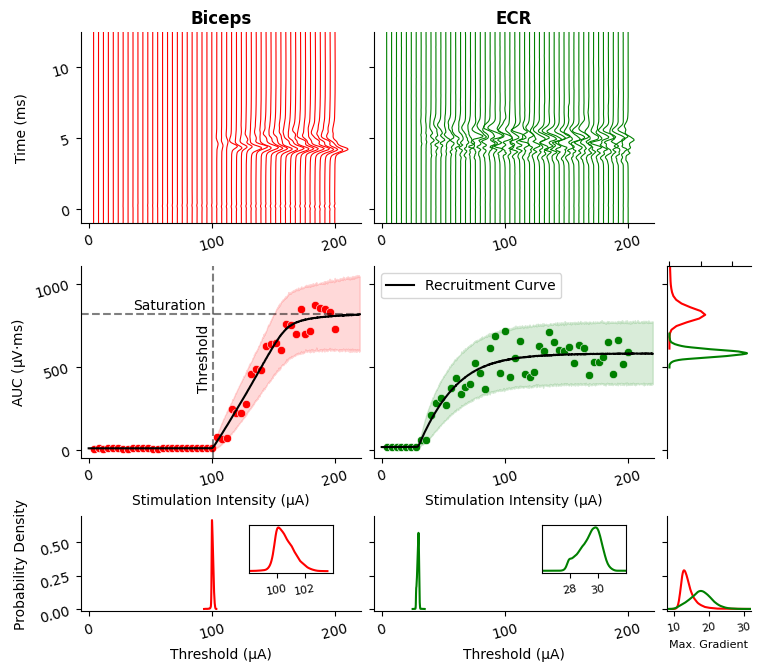

In [266]:
scatter_alpha = 1

a_, b_ = model.mep_window
time = np.linspace(a_, b_, mat.shape[1])
colors = ["r", "g"]
const = [200, 100]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / const[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * time_const, color=colors[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * time_const)
    ax.set_ylim(bottom=-0.001 * time_const, top=(model.mep_size_window[1] + (model.mep_size_window[0] - (-0.001))) * time_const)

    ax = axes[1, muscle_ind]
    sns.lineplot(x=prediction_df[model.intensity], y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color="black", alpha=1, label="Recruitment Curve")
    sns.scatterplot(x=df[model.intensity], y=df[model.response[muscle_ind]] * time_const, color=colors[muscle_ind], alpha=1, ax=ax)
    ax.fill_between(
        prediction_df[model.intensity],
        obs_hpdi[0, ..., muscle_ind],
        obs_hpdi[1, ..., muscle_ind],
        color=colors[muscle_ind],
        alpha=.15
    )
    if ax == axes[1, 0]:
        ax.axvline(x=a_map[0, 0, muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, 0, muscle_ind] - 1, obs_map.max(axis=0)[muscle_ind] - 60, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, 0, muscle_ind] - 35, obs_map.max(axis=0)[muscle_ind] + 10, "Saturation", va="bottom", ha="center")

    ax = axes[2, muscle_ind]
    sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ax, color=colors[muscle_ind])
    ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ins, color=colors[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")
    ins.set_ylim(bottom=-.03)
    if muscle_ind == 0:
        ins.set_xticks([100, 102])
        ins.set_xlim(left=98, right=104)
    if muscle_ind == 1:
        ins.set_xticks([28, 30])
        ins.set_xlim(left=26, right=32)
    ins.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=8,
        labelrotation=10
    )

    ax = axes[1, 2]
    # ax.axhline(obs.mean(axis=0).max(axis=0)[muscle_ind], color="black", linestyle="--")
    if muscle_ind == 0:
        sns.kdeplot(y=H[:, 0, 0, muscle_ind] * time_const + 30, ax=ax, color=colors[muscle_ind])
    if muscle_ind == 1:
        sns.kdeplot(y=H[:, 0, 0, muscle_ind] * time_const + 20, ax=ax, color=colors[muscle_ind])

    ax = axes[2, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    sns.kdeplot(max_grad, ax=ax, color=colors[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 1:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 2:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=10,
            labelsize=8
        )

axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])

axes[0, 0].set_xticks([0, 100, 200])
axes[0, 0].set_yticks([0, 5, 10])
axes[1, 0].set_yticks([0, 500, 1000])
# axes[1, 0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

axes[1, 1].legend(loc="upper left")
if axes[1, 0].get_legend():
    axes[1, 0].get_legend().set_visible(False)

axis_label_size = 10
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$ms)", size=axis_label_size)

axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)

axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])
axes[2, 1].sharey(axes[2, 0])
axes[2, 0].set_ylim(bottom=-0.018)
axes[2, 0].set_ylabel("Probability Density")
# axes[2, 0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

axes[2, 0].set_xlabel("Threshold (µA)", size=axis_label_size)
axes[2, 1].set_xlabel("Threshold (µA)", size=axis_label_size)

axes[2, 2].sharey(axes[2, 0])
axes[2, 2].set_xlim(left=8, right=32)
axes[2, 2].set_xticks([10, 20, 30])
axes[2, 2].set_xlabel("Max. Gradient", size=8)

ax = axes[0, 2]
sides = ['left', 'top', 'bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
)

ax = axes[1, 2]
sides = ['bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=True,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    labelrotation=10,
    labelsize=8
)
axes[1, 2].sharey(axes[1, 0])
# axes[1, 2].set_xlabel("Prob. Density", size=8)
axes[1, 2].xaxis.set_label_position('top')
# axes[1, 2].set_ylabel("Saturation (µV$\cdot$ms)", size=8)
axes[1, 2].set_xlim(left=-0.0006)
axes[1, 2].set_xticks([0, 0.015/2, 0.015])
# axes[1, 2].set_xticklabels([0.0, 0.1, 0.2])
# axes[1, 2].set_ylabel("Saturation (µA)", size=8)

axes[0, 0].set_title("Biceps", fontweight="bold")
axes[0, 1].set_title("ECR", fontweight="bold")

fig.align_ylabels()

dest = os.path.join(model.build_dir, "a-meps.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "a-meps.png")
fig.savefig(dest, dpi=600)

In [202]:
dest

'/home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/a-meps.png'

(16000, 1000, 2)

In [198]:
# obs_min = obs_map.min(axis=0)[None, None, ...]
# obs_max = obs_map.max(axis=0)[None, None, ...]

obs_min = obs.min(axis=1)[:, None, :]
obs_max = obs.max(axis=1)[:, None, :]

obs_max.shape

(16000, 1, 2)

(16000, 1, 2)

In [147]:
obs_norm = (obs - obs_min)/ (obs_max - obs_min)
obs_norm.shape

obs_norm_hpdi = hpdi(obs_norm, prob=.95)


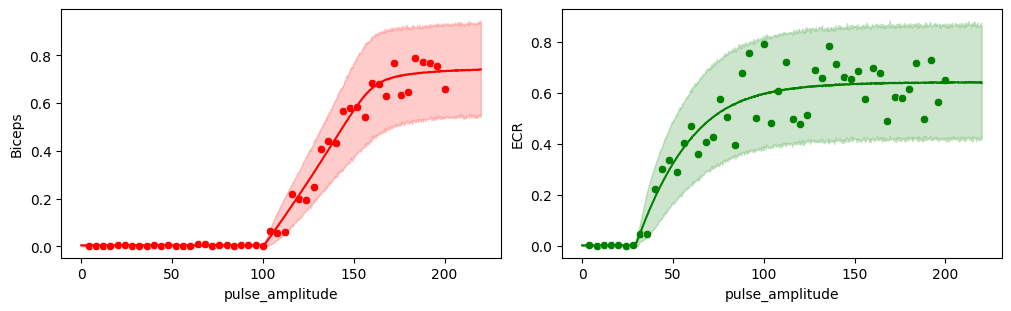

In [159]:
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    sns.lineplot(x=intensity[0, :, 0], y=obs_norm.mean(axis=0)[..., muscle_ind], color=colors[muscle_ind], ax=ax)
    sns.scatterplot(x=df[model.intensity], y=((df[model.response[muscle_ind]] * time_const) - obs_min.mean(axis=0)[0, muscle_ind]) / ((obs_max - obs_min).mean(axis=0)[0, muscle_ind]), color=colors[muscle_ind], ax=ax)
    ax.fill_between(
        intensity[0, :, 0],
        obs_norm_hpdi[0, :, muscle_ind],
        obs_norm_hpdi[1, :, muscle_ind],
        color=colors[muscle_ind],
        alpha = .2
    )


In [180]:
obs_norm_sum = obs_norm.sum(axis=-1)[..., None]
obs_norm_sum.shape

(16000, 1000, 1)

In [181]:
obs_ratio = np.divide(obs_norm, obs_norm_sum, out=np.zeros_like(obs_norm), where=obs_norm!=0)
obs_ratio.shape


(16000, 1000, 2)

<Axes: >

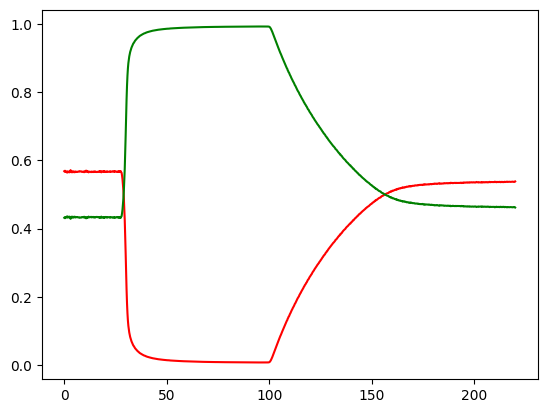

In [189]:
muscle_ind = 0
sns.lineplot(x=intensity[0, :, 0], y=obs_ratio.mean(axis=0)[..., muscle_ind], color=colors[muscle_ind])

muscle_ind = 1
sns.lineplot(x=intensity[0, :, 0], y=obs_ratio.mean(axis=0)[..., muscle_ind], color=colors[muscle_ind])


In [182]:
from scipy.special import entr


In [185]:
entropy = entr(obs_ratio)
entropy.shape

(16000, 1000, 2)

<Axes: >

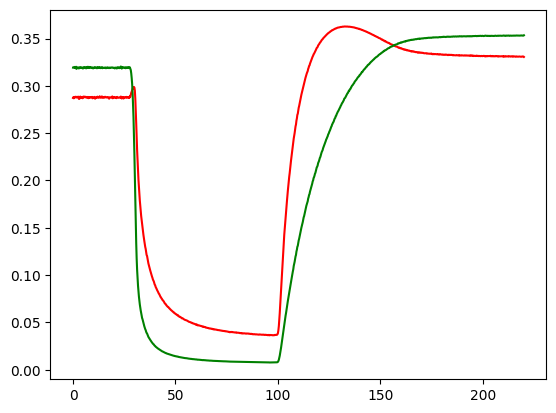

In [188]:
muscle_ind = 0
sns.lineplot(x=intensity[0, :, 0], y=entropy.mean(axis=0)[..., muscle_ind], color=colors[muscle_ind])

muscle_ind = 1
sns.lineplot(x=intensity[0, :, 0], y=entropy.mean(axis=0)[..., muscle_ind], color=colors[muscle_ind])

<Axes: >

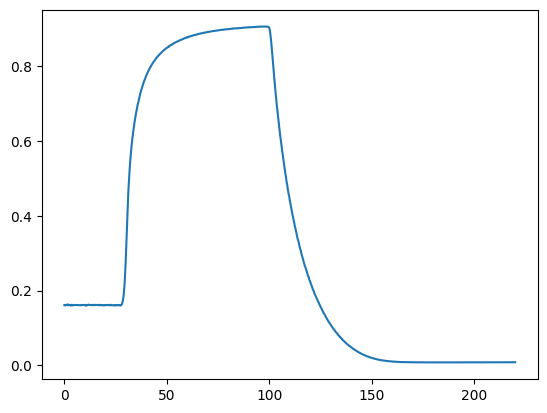

In [103]:
entropy_adj = 1 + (
    (obs_ratio * jnp.log(obs_ratio)).sum(axis=-1)
    / jnp.log(model.n_response)
)
entropy_adj.shape

sns.lineplot(x=intensity[0, :, 0], y=entropy_adj.mean(axis=0))


<Axes: >

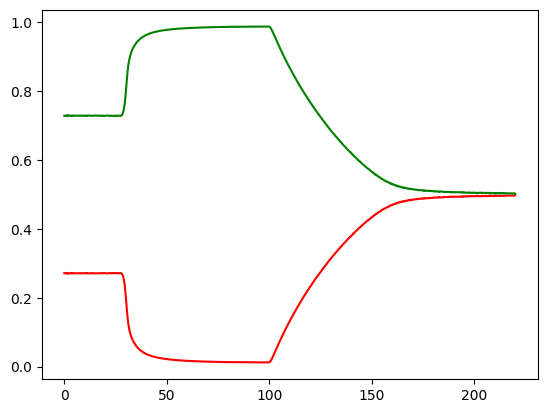

In [124]:
muscle_ind = 0
sns.lineplot(x=intensity[0, :, 0], y=obs_ratio.mean(axis=0)[..., muscle_ind], color=colors[muscle_ind])

muscle_ind = 1
sns.lineplot(x=intensity[0, :, 0], y=obs_ratio.mean(axis=0)[..., muscle_ind], color=colors[muscle_ind])


In [95]:
obs_ratio.shape

(16000, 1000, 2)

In [513]:
type(fn_out)

numpy.ndarray

In [510]:
np.array(b)[:, ind, 0]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 1 but corresponding boolean dimension is 2000

<Axes: >

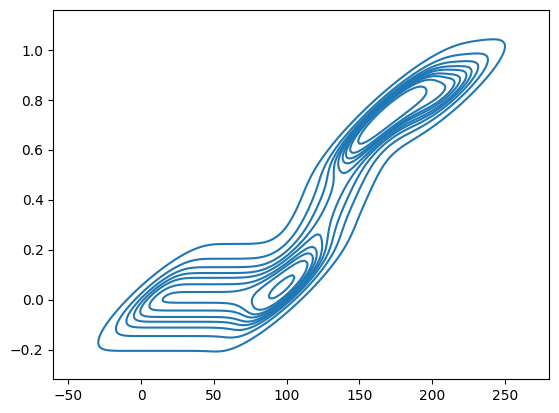

In [516]:
c = (0, 0)
ind = prediction_df[model.combination_columns].apply(tuple, axis=1).isin([c])


sns.kdeplot(x=intensity[0, ind, 0], y=fn_out.mean(axis=0)[ind, 0])
